In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor

In [3]:
# Set the torch seed for deterministic behavior
torch.manual_seed(0);

In [4]:
train_data = torchvision.datasets.MNIST(
    '/tmp',
    train=True,
    download=True,
    transform=ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

In [5]:
test_data = torchvision.datasets.MNIST(
    '/tmp',
    train=True,
    download=True,
    transform=ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

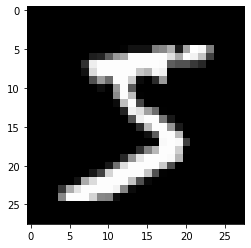

In [43]:
plt.imshow(test_data[0][0].numpy()[0,:,:], cmap='gray')

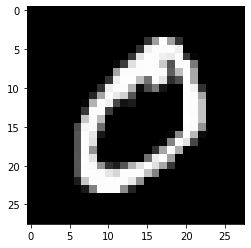

In [44]:
plt.imshow(test_data[1][0].numpy()[0,:,:], cmap='gray')

In [6]:
class LinearMNIST(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        y = self.linear_stack(x)
        return y

In [7]:
model = LinearMNIST()

In [8]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300593  [    0/60000]
loss: 1.613943  [ 6400/60000]
loss: 1.586333  [12800/60000]
loss: 1.590376  [19200/60000]
loss: 1.573111  [25600/60000]
loss: 1.608075  [32000/60000]
loss: 1.591978  [38400/60000]
loss: 1.513969  [44800/60000]
loss: 1.527455  [51200/60000]
loss: 1.580671  [57600/60000]
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.023849 

Epoch 2
-------------------------------
loss: 1.533464  [    0/60000]
loss: 1.533781  [ 6400/60000]
loss: 1.497141  [12800/60000]
loss: 1.510093  [19200/60000]
loss: 1.489342  [25600/60000]
loss: 1.487759  [32000/60000]
loss: 1.533878  [38400/60000]
loss: 1.496870  [44800/60000]
loss: 1.502997  [51200/60000]
loss: 1.511436  [57600/60000]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.023473 

Epoch 3
-------------------------------
loss: 1.466511  [    0/60000]
loss: 1.516493  [ 6400/60000]
loss: 1.507017  [12800/60000]
loss: 1.477768  [19200/60000]
loss: 1.498860  [25600/60000]
loss: 1.534850  [32000/600

In [11]:
y_pred = model(test_data[0][0])
y_pred, y_pred.argmax(), test_data[0][1]

(tensor([[1.3431e-17, 4.0926e-13, 5.2853e-11, 2.7454e-05, 7.5811e-35, 9.9997e-01,
          1.1170e-27, 4.5161e-21, 3.1156e-16, 2.5034e-17]],
        grad_fn=<SoftmaxBackward>),
 tensor(5),
 5)

In [12]:
torch.onnx.export(
    model,
    (test_data[0][0]),
    'linear_mnist.onnx',
    verbose=True,
    input_names=['x'],
    output_names=['output'],
    dynamic_axes={
        'x': {0: 'batch_size',},
        'output': {0: 'batch_size'},
    }
)

graph(%x : Float(1:1, 28:28, 28:1, requires_grad=0, device=cpu),
      %linear_stack.0.weight : Float(512:784, 784:1, requires_grad=1, device=cpu),
      %linear_stack.0.bias : Float(512:1, requires_grad=1, device=cpu),
      %linear_stack.2.weight : Float(10:512, 512:1, requires_grad=1, device=cpu),
      %linear_stack.2.bias : Float(10:1, requires_grad=1, device=cpu)):
  %5 : Float(1:784, 784:1, requires_grad=0, device=cpu) = onnx::Flatten[axis=1](%x) # <ipython-input-6-44d3786d2375>:13:0
  %6 : Float(1:512, 512:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%5, %linear_stack.0.weight, %linear_stack.0.bias) # /home/colin/.miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1690:0
  %7 : Float(1:512, 512:1, requires_grad=1, device=cpu) = onnx::Relu(%6) # /home/colin/.miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1136:0
  %8 : Float(1:10, 10:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., tra

In [13]:
!mv linear_mnist.onnx ../src/main/resources/